Process Michilli 9 Subbursts
=====

In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0



In [40]:
folder = 'data'
outfolder = 'figures'
sigmax_error = []
sigmay_error = []
angle_error  = []
drift_errors = []
drifts       = []
autocorrs    = []
auto_sigmas  = []
red_chisqs   = []
corredges = [(10, 300)]

for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    if 'gajjar' in filename:
        continue
    if burst != 9:  continue
    
    print('processing {}'.format(filename))

    #junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    #Q, U, V = None, None, None
    
    junk, nchan, nbin, I = [], [], [], []
    with open('{}/{}'.format(folder, filename)) as infile:
        for line in infile:
            junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
            junk.append(junki)
            nchan.append(nchani)
            nbin.append(nbini)
            I.append(Ii)
    junk  = np.array(junk, dtype=float)
    nchan = np.array(nchan, dtype=float)
    nbin  = np.array(nbin, dtype=float)
    I     = np.array(I, dtype=float)
    
    n = len(junk)
    edge = int(edge)
    print("Data loaded")
    
    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    #### 2. find autocorrelation 
    burstwindow = intensity[:,edge:edge+frequencymax]

  0%|          | 0/26 [00:00<?, ?it/s]

processing 09_puppi_57747_C0531+33_0558_3690.dm559.72.calibP.RM.DD.ASCII
Data loaded


100%|██████████| 26/26 [00:12<00:00,  2.16it/s]


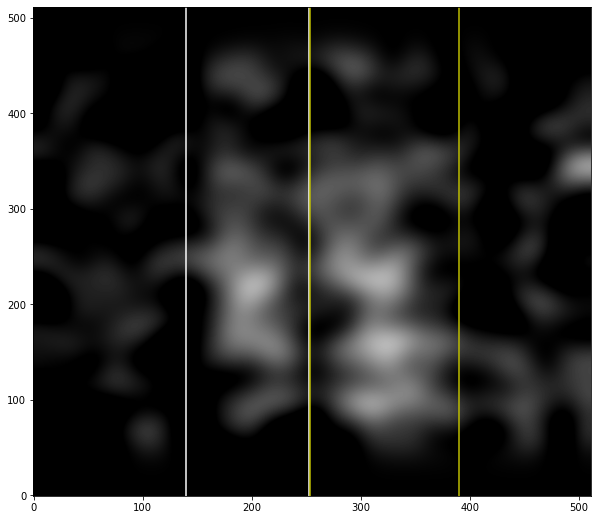

In [149]:
plt.figure(figsize=(10,9))
cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!


blurred = gaussian_filter(burstwindow, sigma=15)
# plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.imshow(blurred, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.clim(0, np.max(burstwindow)/50)

burst9a_edges = [140, 252]
burst9b_edges = [253, 390]

burst9a = burstwindow[:, burst9a_edges[0]:burst9a_edges[1]]
burst9b = burstwindow[:, burst9b_edges[0]:burst9b_edges[1]]

for x in burst9a_edges: plt.axvline(x=x, c='w')
for x in burst9b_edges: plt.axvline(x=x, c='y')
plt.savefig('Burst9_parition.png')

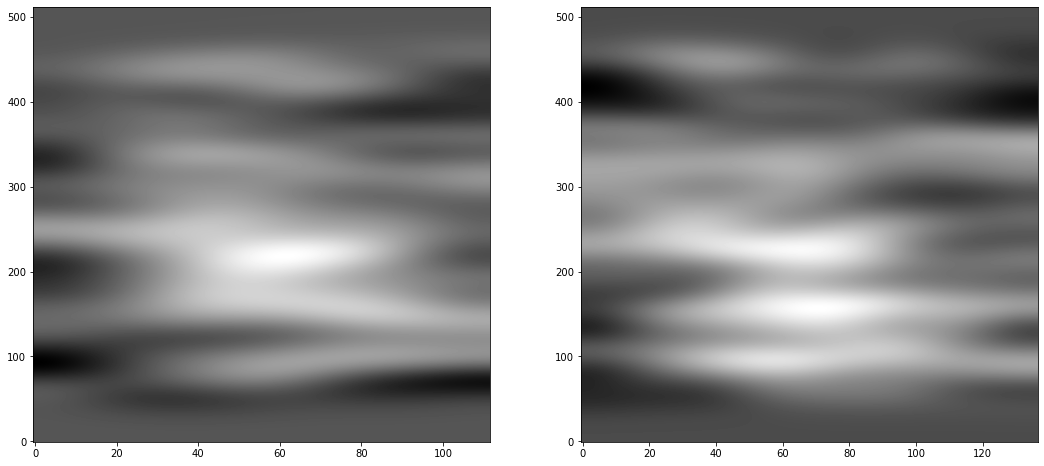

In [69]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(gaussian_filter(burst9a, sigma=15), cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.subplot(122)
plt.imshow(gaussian_filter(burst9b, sigma=15), cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")

In [70]:
    print("finding auto-correlation...")
    #corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
    #print(corr.shape)
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    burst9a_corr = corrfns.auto_corr2D_viafft(burst9a)
    burst9b_corr = corrfns.auto_corr2D_viafft(burst9b)    

finding auto-correlation...


In [71]:
    def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
        x, y = point
        xo = float(xo)
        yo = float(yo)
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
        return g.ravel()

    def fitgaussiannlsq(data, sigma=0):
        # use curve-fit (non-linear leastsq)
        x = range(0, data.shape[1]); y = range(0, data.shape[0])
        x, y = np.meshgrid(x, y)
        params = moments(data)#+ (0.,)
        sigma = np.zeros(len(data.ravel())) + sigma
        popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (y, x), data.ravel(), p0=params, sigma=sigma, absolute_sigma=True)
        return popt, pcov

    #### 2.5 Autocorr noise
    autocorr_sigma = np.std( corr[:, corredges[0][0]:corredges[0][1]] )
    print('autocorr_sigma', autocorr_sigma)
    auto_sigmas.append(autocorr_sigma)

    #### 3. Fit Gaussian to autocorrelation
    print("finding fit...")
    popt, pcov = fitgaussiannlsq(corr, sigma=autocorr_sigma)
    popt9a, pcov9a = fitgaussiannlsq(burst9a_corr, sigma=autocorr_sigma)
    popt9b, pcov9b = fitgaussiannlsq(burst9b_corr, sigma=autocorr_sigma) 

    perr = np.sqrt(np.diag(pcov))
    perr9a = np.sqrt(np.diag(pcov9a))
    perr9b = np.sqrt(np.diag(pcov9b))
    print('solution nlsq:', popt)
    print('solution nlsq:', popt9a)
    print('solution nlsq:', popt9b)
    # print('parameter 1sigma:', perr)
    # print('pcov diag:', np.diag(pcov))
    # with np.printoptions(precision=3, suppress=True):
        # print('pcov:')
        # print(pcov)

autocorr_sigma 3.7926402244774153
finding fit...
solution nlsq: [  3.55511878 512.36849408 512.3103574   89.61698616 133.40842557
   4.04019585]
solution nlsq: [   1.82214567  512.57116058  112.42456204  -24.65229921 -113.94825411
    4.61182442]
solution nlsq: [  3.01900396 512.05570061 137.47506428 137.31759484 -39.61312096
   9.30912765]


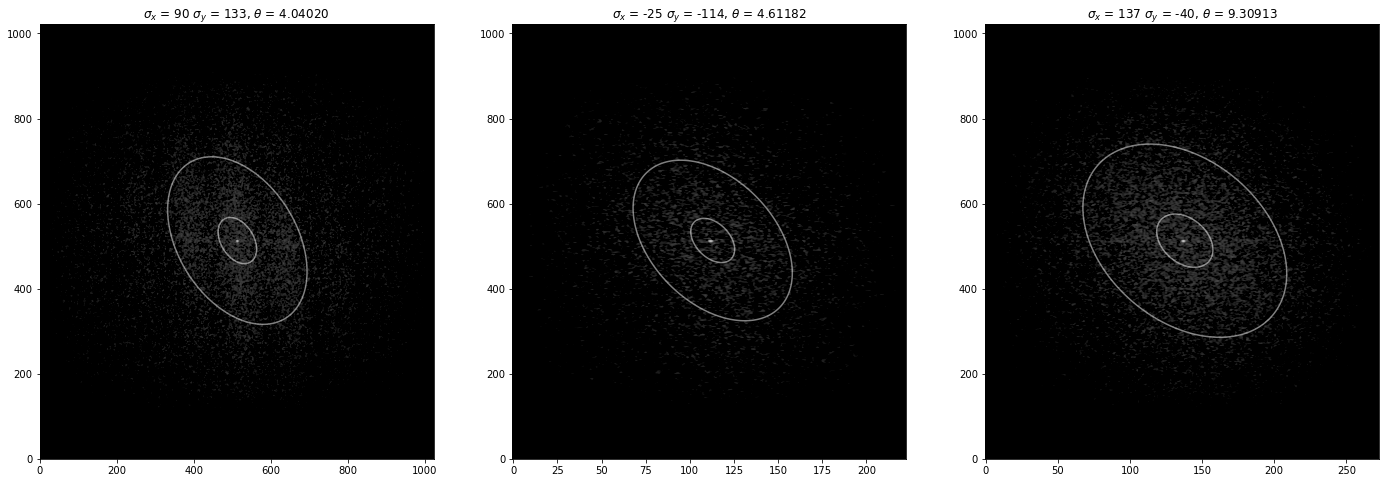

In [73]:
    # Plot and reduced chisquare
    aspect = 'auto'
    plt.figure(figsize=(24,8))
    plt.subplot(131)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt[3], popt[4], popt[5]))
    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower')
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    
    plt.subplot(132)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt9a[3], popt9a[4], popt9a[5]))
    x, y = np.meshgrid(range(0, burst9a_corr.shape[1]), range(0, burst9a_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt9a).reshape(burst9a_corr.shape[0], burst9a_corr.shape[1])
    plt.imshow(burst9a_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt9a[0]/4, popt9a[0]*0.9], colors='w', alpha=0.5, origin='lower')
    residuals = burst9a_corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq9a = chisq / (burst9a_corr.shape[0]*burst9a_corr.shape[1] - len(popt)) # this is chisq/(M-N)
    
    plt.subplot(133)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt9b[3], popt9b[4], popt9b[5]))
    x, y = np.meshgrid(range(0, burst9b_corr.shape[1]), range(0, burst9b_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt9b).reshape(burst9b_corr.shape[0], burst9b_corr.shape[1])
    plt.imshow(burst9b_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt9b[0]/4, popt9b[0]*0.9], colors='w', alpha=0.5, origin='lower')
    residuals = burst9b_corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq9b = chisq / (burst9b_corr.shape[0]*burst9b_corr.shape[1] - len(popt)) # this is chisq/(M-N)
    

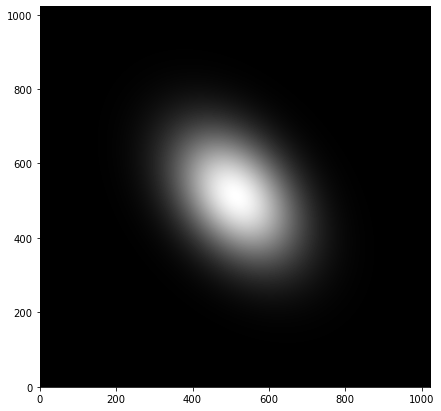

In [138]:
    plt.figure(figsize=(7,7))
    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    testtheta = 0.4
    opts = popt
    fitmap = twoD_Gaussian((y, x), *opts).reshape(corr.shape[0], corr.shape[1])
    plt.imshow(fitmap, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")

In [134]:
    ### 3.5 Compute drift and error
    angles = np.array([popt[-1], popt9a[-1], popt9b[-1]])
    thetas = (np.array([-popt[-1],   -popt9a[-1],   np.pi/2-popt9b[-1] - np.pi])) % (2*np.pi)
    theta_errs = np.array([perr[-1], perr9a[-1], perr9b[-1]])
    sigmax_errors = np.array([perr[3], perr9a[3], perr9b[3]])
    sigmay_errors = np.array([perr[4], perr9a[4], perr9b[4]])
    slopes = np.tan(thetas)
    
    chan_width = 1.5625 # MHz
    time_resolution = 0.01024 / 1e3 # ms
    conversion = chan_width / (time_resolution * 1e3)
    drifts = conversion * slopes # MHz/ms
    drift_errors = conversion * (theta_errs * (1/np.cos(thetas))**2)

    print('angles:', angles)
    print('thetas:', thetas)
    print('slopes:', slopes)
    print('drift:', drifts)
    print('drift error:', drift_errors)
    driftresults = pd.DataFrame({
        'angle': angles,
        'theta': thetas,
        'slope': slopes,
        'drift(MHz/ms)': drifts,
        'drift error': drift_errors,
        'sigmax'     : [popt[3], popt9a[3], popt9b[3]],
        'sigmay'     : [popt[4], popt9a[4], popt9b[4]],
        'sigmax_error': sigmax_errors,
        'sigmay_error': sigmay_errors,
        'angle_error': theta_errs,
        'red_chisq'  : [red_chisq, red_chisq9a, red_chisq9b]
    }, index=['9','9a','9b'])

driftresults

angles: [4.04019585 4.61182442 9.30912765]
thetas: [2.24298945 1.67136089 1.68644664]
slopes: [-1.25654965 -9.91031673 -8.60817138]
drift: [ -191.73426083 -1512.19432564 -1313.5027123 ]
drift error: [  5.29642772 152.48691827  69.30909944]


,angle,theta,slope,drift(MHz/ms),drift error,sigmax,sigmay,sigmax_error,sigmay_error,angle_error,red_chisq
9,4.040196,2.242989,-1.256550,-191.734261,5.296428,89.616986,133.408426,0.697537,1.038899,0.013459,3.361416
9a,4.611824,1.671361,-9.910317,-1512.194326,152.486918,-24.652299,-113.948254,0.772813,3.567355,0.010073,0.754693
9b,9.309128,1.686447,-8.608171,-1313.502712,69.309099,137.317595,-39.613121,1.866474,0.538615,0.006048,0.903205


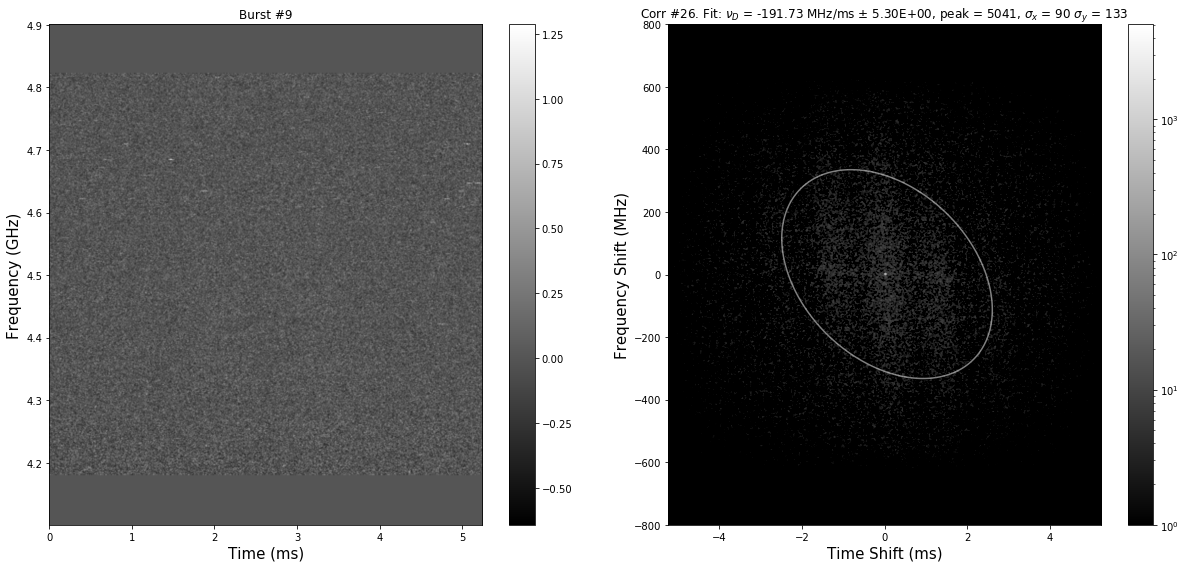

In [143]:
    chan_width = 1.5625 # MHz
    time_resolution = 0.01024 / 1e3 # s
    lowestfreq = 4100.78125 # MHz

    burstextents = [0, 
       time_resolution * burstwindow.shape[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    burst9aextents = [time_resolution * burst9a_edges[0] * 1e3, 
       time_resolution * burst9a_edges[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    burst9bextents = [time_resolution * burst9b_edges[0] * 1e3, 
       time_resolution * burst9b_edges[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    
    corrextents = [-time_resolution * (corr.shape[1]/2) * 1e3, 
       time_resolution * (corr.shape[1]/2) * 1e3 , 
       (lowestfreq -  (2*lowestfreq + chan_width*burstwindow.shape[0])/2 )*2, 
       ((lowestfreq + chan_width*burstwindow.shape[-2]) -  (2*lowestfreq + chan_width*burstwindow.shape[0])/2 )*2]
    corr9aextents = [-time_resolution * (burst9a_corr.shape[1]/2) * 1e3, 
           time_resolution * (burst9a_corr.shape[1]/2) * 1e3 , 
           corrextents[2],
           corrextents[3]]
    corr9bextents = [-time_resolution * (burst9b_corr.shape[1]/2) * 1e3, 
           time_resolution * (burst9b_corr.shape[1]/2) * 1e3 , 
           corrextents[2],
           corrextents[3],]
    
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst #{}".format(9))
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.colorbar()

    plt.subplot(122)
    plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drifts[0], drift_errors[0], np.max(corr), popt[3], popt[4]))
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.colorbar()   
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    # plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    # print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

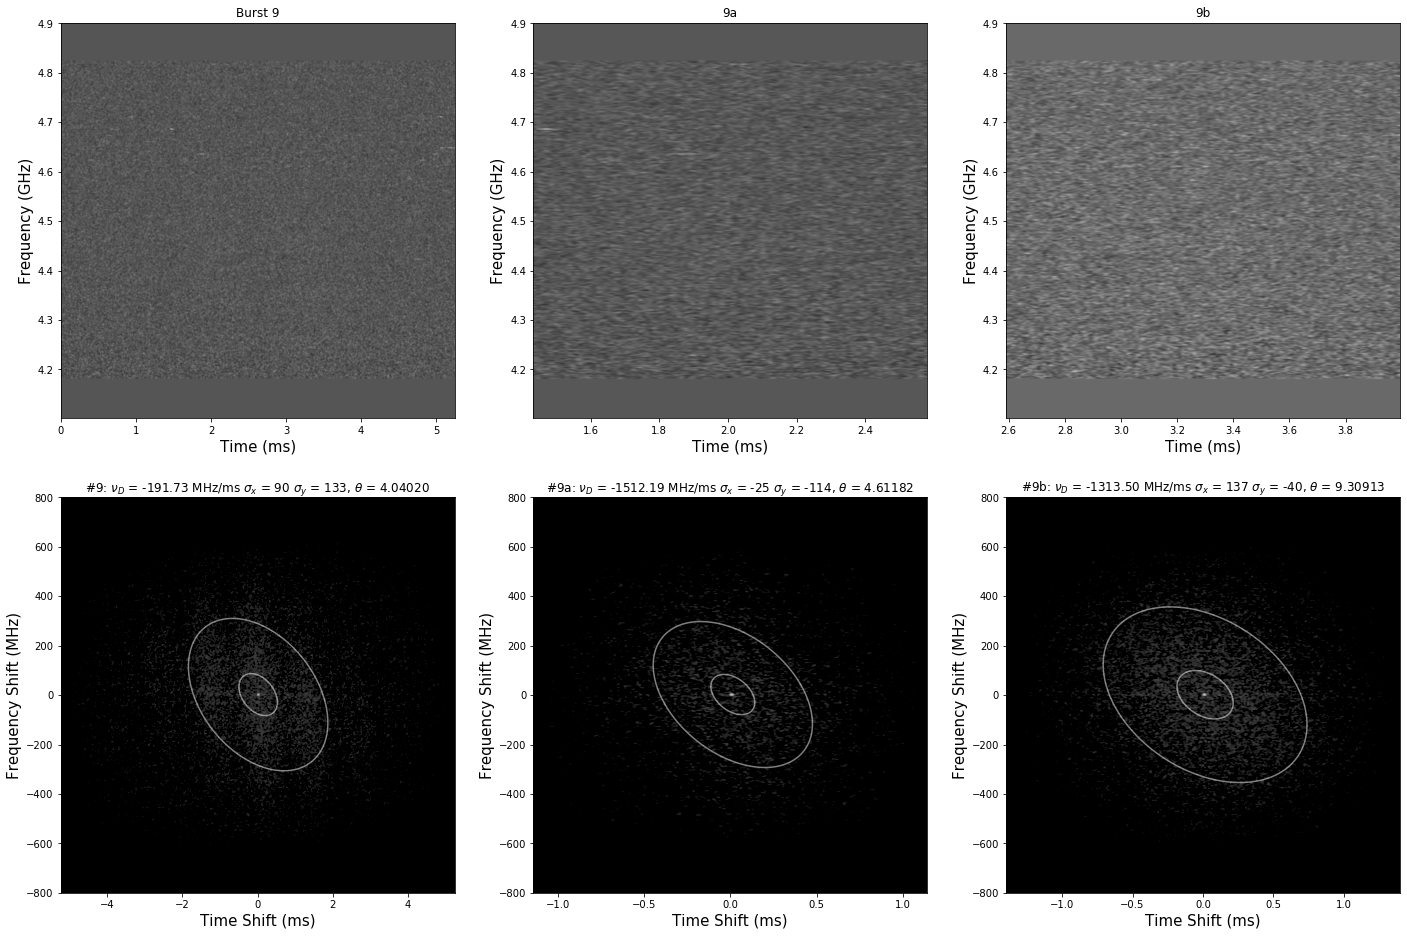

In [150]:
    # Plot 
    aspect = 'auto'
    plt.figure(figsize=(24,16))
    plt.subplot(231)
    plt.title('Burst 9')
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.subplot(232)
    plt.title('9a')
    plt.imshow(burst9a, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burst9aextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.subplot(233)
    plt.title('9b')
    plt.imshow(burst9b, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burst9bextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    
    plt.subplot(234)
    plt.title("#9: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[0], popt[3], popt[4], popt[5]))
    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)
    
    plt.subplot(235)
    plt.title("#9a: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[1], popt9a[3], popt9a[4], popt9a[5]))
    x, y = np.meshgrid(range(0, burst9a_corr.shape[1]), range(0, burst9a_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt9a).reshape(burst9a_corr.shape[0], burst9a_corr.shape[1])
    plt.imshow(burst9a_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corr9aextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt9a[0]/4, popt9a[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corr9aextents)
    
    plt.subplot(236)
    plt.title("#9b: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[2], popt9b[3], popt9b[4], popt9b[5]))
    x, y = np.meshgrid(range(0, burst9b_corr.shape[1]), range(0, burst9b_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt9b).reshape(burst9b_corr.shape[0], burst9b_corr.shape[1])
    plt.imshow(burst9b_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corr9bextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt9b[0]/4, popt9b[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corr9bextents)
    plt.savefig('Burst9Subbursts.png')

In [ ]:
print(burst10aextents, corr10aextents)
print(burst10bextents, corr10bextents)
print(burstextents, corrextents)


In [ ]:
print(np.array(burst10a_edges)*time_resolution)
print(np.array(burst10b_edges)*time_resolution)